# Part 1: Data Cleaning

Our project requires integrating information from the following data sources:

- Human data
    - Data on human brucellosis cases in Iran from 2015 to 2018
    - Conatins demographic information on each case as well as information on past interaction with livestock, livestock vaccination status, and any known link to unpasteurized dairy consumption
- Animal data
    - Data on brucellosis incidence in livestock in Iran from 2009 to 2017
    - Contains results from sampling of barns across the country (includes number of animals sampled, number infected, number healthy, and number of suspicious cases)
- Socioeconomic status data
    - Data containing average household size and socioeconomic status quintile at the province level
- Population data
    - Contains state-reported population data for each county
- Environmental data
    - NDVI, temperature, humidity, and precipitation data obtained using Google Earth Engine
- Spatial data
    - Shapefile of Iranian counties
    
In the code sections below, we read in each of these datasets in turn (environmental data is saved for later in the script).

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import Levenshtein as leven

In [2]:
## File path
fp = '/Users/mohsen/Desktop/Brucellosis Project/CLean/Project-Repo-master/Data/'
fp2 = '/Users/mohsen/Desktop/Brucellosis Project/CLean/Project-Repo-master'

## Read animal data and update columns
animal_data = pd.read_csv(fp + 'animal_vac_data.csv')
animal_data.columns = ['id', 'unitCode', 'unitType', 'province',
                       'county', 'livestock_type', 'time_j', 'time_g',
                       'lat' , 'long', 'n_sample', 'n_checked', 'n_infected', 
                       'n_rejected', 'n_suspicious']

## Create new columns storing month and year of animal testing
animal_data[['month', 'year']] = animal_data['time_g'].str.split('/', expand = True)[[0,2]]

Shapefile data:

In [3]:
## Read in Iran shapefile data
iran_data = gpd.read_file(fp2 + '/Iran_shp/iran_admin.shp')

## Subset to relevant columns and update names
iran_data = iran_data[['ADM2_EN','ADM2_FA','ADM1_EN','ADM1_FA','Shape_Leng','Shape_Area','geometry']]
iran_data.columns = ['county_en', 'county_fa', 'province_en', 'province_fa', 'shape_len', 'shape_area', 'geometry']

## This accidental escape sequence is problematic later, so deal with manually here
iran_data.loc[iran_data['county_en'] == 'Yasooj\r', 'county_en'] = 'Yasooj'

Human data:

In [4]:
## Read in human data and rename columns
human_data = pd.read_csv(fp + 'Human_Brucellosis_2015-2018_V3.csv')
human_data = human_data.rename(columns = {'Urban/Rural/Itinerant/Nomadic':'Pop_setting',
                                          'Prepnancy':'Pregnancy',
                                          'Occuptio':'Occupation',
                                          'Livestock interaction history':'Livestock_int_hist',
                                          'Livestock interaction type':'Livestock_int_type',
                                          'Unpasteurized dairy consumption ':'Unpast_dairy',
                                          'Other family members infection':'Fam_members_inf',
                                          'Outbreak Year':'Outbreak_yr',
                                          'Outbreak Month':'Outbreak_mth',
                                          'Diagnosis Year':'Diagnosis_yr',
                                          'Diagnosis Month':'Diagnosis_mth',
                                          'Livestock vaccination history':'Livestock_vac_hist'})

## Fix duplicate provinces (present both capitalized and uncapitalized)
human_data.loc[human_data['Province'] == 'Khorasan jonobi', 'Province'] = 'Khorasan Jonobi'
human_data.loc[human_data['Province'] == 'Khorasan shomali', 'Province'] = 'Khorasan Shomali'

Socioeconomic status data:

In [7]:
## Read in SES data and rename columns
ses_data = pd.read_csv(fp + 'ses_data.csv')[['province', 'pop', 'hshld_size', 'ses']]

County-level population data:

In [10]:
## Read in population data
pop_data = pd.read_csv(fp + 'pop_by_county.csv', skiprows = [1, 2, 3, 4], usecols = [0, 1])

## Remove unneeded rows
pop_data = pop_data.drop(pop_data[pop_data['Description'].str.contains("Setteled", case = False)].index)
pop_data = pop_data.drop(pop_data[pop_data['Description'].str.contains("Settled", case = False)].index)

## Trim strings
pop_data['Description'] = pop_data['Description'].str.strip()
pop_data['Population'] = pop_data['Population'].str.replace(',', '').astype(int)

## Identifying Name Discrepancies

Of course, working with data from a variety of sources requires extensive data preparation and cleaning to ensure the correct observations are matched when merging the data into a single source.

We discovered quickly that translations of province and county names from Persian to English varied widely across the datasets. This presented serious problems for our ability to merge datasets, as even single character differences between county names across the datasets would prevent the data from being matched properly. However, given the more than 400 distinct counties in Iran, it was impractical to attempt to manually identify the discrepancies and update the names accordingly. To speed up our ability to identify county name discrepancies, we defined three functions to help identify many of the matches automatically:

- match_names
- likely_matches
- map_caps

### Function: match_names

match_names is a function that iterates through two user-supplied lists of strings and calculates the Levenshtein distance and Levenshtein ratio between the distinct pairings of strings between the two lists. It then assembles a dataframe displaying the matches that each method (Levenshtein distance or Levenshtein ratio) identifies as the best possible match. The function will find a potential match for all strings in the first list, but will not necessarily find a match for all strings in the second list passed.

The Levenshtein distance and Levenshtein ratio are string similarity metrics that rely on the number of individual character changes are required to convert one string into another. More information can be found [here](https://en.wikipedia.org/wiki/Levenshtein_distance).

There are a few options for the user to specify:

- __as_df:__ if True, returns a single dataframe with the automatically identified optimum matches. If False, returns a dictionary of where each string in the first list is represented as a key. The associated values are dataframes of all the Levenshtein distances and ratios for that key string when matched to each word in the second list. (This allows for more granular investigation when the top match seems questionable.)
- __caps:__ if True, standardizes capitalization of all strings before matching. May improve match success depending on the format of the strings passed to the function
- __unique:__ if True, the function only attempts to match names that don't already have a perfect match. This usually improves accuracy since it removes the possiblity of matching a string in the first list to a value that already has a perfect match to another string in the second list. However, when a one-to-one matching isn't expected, setting this to False may improve accuracy.

In [11]:
## Function to match potential misspelled strings
## Takes two lists, calculates Levenshtein distance and ratio to identify potential matches
## Used in the likely_matches function
def match_names(s1, s2, as_df = True, caps = True, unique = True):
    
    s1 = pd.Series(s1)
    s2 = pd.Series(s2)
    
    ## Get unique values in each series
    vals1 = s1.unique()
    vals2 = s2.unique()
    
    ## If unique argument is set to true, only match names that don't already have perfect match
    if unique == True:
        
        ## Unique values in series 1 that aren't in series 2
        vals1 = pd.Series(np.setdiff1d(vals1, vals2))
    
        ## Unique values in series 2 that aren't in series 1
        vals2 = pd.Series(np.setdiff1d(vals2, vals1))
        
    if caps == True:
        
        ## Capitalize before matching
        vals1 = vals1.str.capitalize()
        vals2 = vals2.str.capitalize()
        
    ## Calculate Levenshtein distance and ratio
    dists = np.array([leven.distance(name1, name2) for name1 in vals1 for name2 in vals2])
    ratios = np.array([leven.ratio(name1, name2) for name1 in vals1 for name2 in vals2])
        
    ## Reshape and convert to df so we can identify which values are for which name combo
    dists_df = pd.DataFrame(data = dists.reshape(len(vals1), len(vals2)), index = vals1, columns = vals2)
    ratios_df = pd.DataFrame(data = ratios.reshape(len(vals1), len(vals2)), index = vals1, columns = vals2)
    
    if as_df == True:
        
        ## Get column names where min distance and max ratio occurs
        matches = pd.DataFrame({'name_dist': dists_df.idxmin(axis = 1), 
                                'name_ratio': ratios_df.idxmax(axis = 1), 
                                'dist': dists_df.min(axis = 1), 
                                'ratio': ratios_df.max(axis = 1)})
    
        return(matches)
        
    ## If user wants more detail, we can create a dictionary for each name that contains more graunlar info
    ## This section creates a dictionary with names as keys and dataframes as values
    ## Each dataframe contains all the possible name pairings (as opposed to above, which only supplies best possible values)
    else:
        
        ratios_dict = {name1: ratios_df.loc[name1].sort_values(ascending = False) for name1 in vals1}
        dists_dict = {name1: dists_df.loc[name1].sort_values() for name1 in vals1}
        
        comb_dict = {name1: pd.merge(dists_dict[name1], ratios_dict[name1], left_index = True, right_index = True, suffixes=('_dist', '_ratio')) for name1 in vals1}
        
        return(comb_dict)

### Function: likely_matches

likely_matches uses the match_names function to identify potential name matches, but also checks to determine whether the optimum match identified by the Levenshtein distance method and Levenshtein ratio method are the same. If both of these guesses are the same and the ratio is sufficiently high, the function populates a dataframe identifying those matches in a new column. This allows the user to easily identify which strings had accurate matches and which remain unmatched (either because the Levenshtein ratio is not sufficiently high or the two methods disagree about the best match).

In addition to the arguments that can be specified in match_names, likely_matches also allows the user to specify the ratio cutoff that will be used to classify strings as matched or unmatched.

In [12]:
## Function to return highly probable string matches - the rest will have to be done manually
## Depends on match_names function
## The index of the resulting df contains values from the *first* series passed to the function
def likely_matches(s1, s2, cutoff = 0.75, as_df = True, caps = True, unique = True):
    
    ## Create dataframe recording potential name matches
    matched = match_names(s1, s2, as_df = as_df, caps = caps, unique = unique)
    
    ## Add column recording whether distance and ratio identify the same match
    matched['name_match'] = (matched['name_dist'] == matched['name_ratio'])
    
    ## Can be highly confident when nameMatch = True, ratio >= .75 - this matches 145 of the 192 that need matches
    matched['matched'] = np.where((matched['name_match'] == True) & (matched['ratio'] >= cutoff), matched['name_dist'], 'NULL')
           
    return(matched)

### Function: map_caps

This is a small helper function to be used in conjunction with match_names and likely_matches. When caps is set to True in either of those functions, strings are capitalized before matching. We found that this typically improves matching accuracy, but it is important to be able to revert the strings back to their original form before the capitalization. 

map_caps simply creates a dictionary mapping a list of strings to their capitalized values. Then, regardless of whether match_names and likely_matches are used with capitalization or not, the user can easily find the original string values before the matching process.

In [13]:
## Little helper function that creates a dictionary mapping capitalized values
## to original values (so we can go back and forth more easily)
def map_caps(s1):
    
    s1 = pd.Series(s1)
    
    ## Capitalize series values
    s1_caps = s1.str.capitalize().unique()
    
    ## Map original values to capitalized values
    caps_mappings = {name1:name2 for name1, name2 in zip(s1_caps, s1.unique())}
    
    return(caps_mappings)

## Province and County Name Matching

We split the process of matching names for each dataset into province names and county names. For the human data, the likely_matches function only auto-identified 4 matches, but given that all but 10 provinces were consistent across the human data and iran shapefile at the beginning, it was simple to manually match the remaining 6 names. We created a dictionary to store the mappings from the human data province names to their shapefile counterparts and updated the human data dataframe with the corresponding matches.

In [14]:
## Province Matching for human data
provs1 = human_data.loc[human_data['Province'] != 'Null']['Province']
provs2 = iran_data['province_en']

likely_matches(provs1, provs2, caps = False)

,name_dist,name_ratio,dist,ratio,name_match,matched
Azarbaijan Gharbi,Kermanshah,East Azerbaijan,12,0.562500,False,NULL
Azarbaijan Sharghi,Kermanshah,East Azerbaijan,12,0.545455,False,NULL
Chaharmahal & bakhtiari,Chaharmahal and Bakhtiari,Chaharmahal and Bakhtiari,4,0.875000,True,Chaharmahal and Bakhtiari
Esfahan,Isfahan,Isfahan,1,0.857143,True,Isfahan
Khorasan Jonobi,Kerman,North Khorasan,11,0.551724,False,NULL
Khorasan Razavi,Kermanshah,North Khorasan,10,0.551724,False,NULL
Khorasan Shomali,Kermanshah,North Khorasan,10,0.533333,False,NULL
Kohgiluyeh & Boyerahmad,Kohgiluyeh and Boyer-Ahmad,Kohgiluyeh and Boyer-Ahmad,5,0.857143,True,Kohgiluyeh and Boyer-Ahmad
Kordestan,Kurdistan,Lorestan,2,0.823529,False,NULL
Sistan & Bluchestan,Sistan and Baluchestan,Sistan and Baluchestan,4,0.878049,True,Sistan and Baluchestan


In [15]:
## Manual province matchings - this accounts for all discrepancies
match_dict_prov = {
    'West Azerbaijan':'Azarbaijan Gharbi',
    'East Azerbaijan':'Azarbaijan Sharghi',
    'Chaharmahal and Bakhtiari':'Chaharmahal & bakhtiari',
    'Isfahan':'Esfahan',
    'South Khorasan':'Khorasan Jonobi',
    'North Khorasan':'Khorasan Shomali',
    'Razavi Khorasan':'Khorasan Razavi',
    'Kohgiluyeh and Boyer-Ahmad':'Kohgiluyeh & Boyerahmad',
    'Kurdistan':'Kordestan',
    'Sistan and Baluchestan':'Sistan & Bluchestan'
              }

## Invert dictionary - want keys to be from the human data
match_dict_prov = {v: k for k, v in match_dict_prov.items()}

## Update province names in human data with dictionary mappings
human_data['Province'] = human_data['Province'].map(match_dict_prov).fillna(human_data['Province'])

The process of matching counties was more laborious since there were far more counties that needed to be matched, which made it difficult to confirm matches through visual inspection. Still, the likely_matches function reduced the discrepant name pairs from more than 200 to 40 that required manual matching. After populating a dictionary with the automatched names and the manually matched names, we updated the county names in the human data to be consistent with the shapefile county names.

In [16]:
## County Matching
## Remove null values for matching
counties1 = human_data.loc[human_data['County'] != 'Null']['County']
counties2 = iran_data['county_en']

## Create mapping of likely pairs
matched_df = likely_matches(counties1, counties2)
#match_names(counties1, counties2, as_df = False)

#matched_df[matched_df['matched'] == 'NULL']
automatched = matched_df[matched_df['matched'] != 'NULL']

## Revert automatched names back to original form data files and zip matched pairs into dictionary
caps_mappings1 = map_caps(counties1)
caps_mappings2 = map_caps(counties2)

match_dict_cty = dict(zip(automatched.index.map(caps_mappings1), automatched['matched'].map(caps_mappings2)))

## Manual matching
match_dict_man = {
    'Ali Abad Katul':'Aliabad', 
    'Bafgh':'Bafq', 
    'Bandar Qaz':'Bandar-e-Gaz', 
    'Dailam':'Deylam',
    'Gonbad  kavoos':'Gonbad-e-Kavus', 
    'Ijroud':'Eejrud', 
    'Jovein':'Jowayin',
    'Kalale':'Kolaleh',
    'Mahvalat':'Mahvelat', 
    'Menojan':'Manujan', ## auto-matched incorrectly
    'Neyshabur':'Nishapur',  
    'Orzoieyeh':'Arzuiyeh', 
    'Ray':'Rey', 
    'Tehran Jonub':'Tehran', 
    'Tehran Shomal':'Tehran', 
    'Tiran o Karvan':'Tiran-o-Korun',
    'Abadeh Tashk':'Abadeh',
    'Agh Ghala':'Aqqala',
    'Ahvaz e gharb':'Ahvaz',
    'Ahvaz e Shargh':'Ahvaz',
    'Gilan Qarb':'Gilan-e-Gharb',
    'Kharame':'Kherameh',
    'Maraqe':'Maragheh',
    'Tehran Gharb':'Tehran',
    'Tehran Shargh':'Tehran',
    'Tehran Shomal Qarb':'Tehran',
    'Zaveh':'Zave',
    'Bandar Mahshahr':'Mahshahr',
    'Qale ganj':'Ghaleye-Ganj',
    'Sarchahan':'Hajiabad',
    'Kamfirouz':'Marvdasht',
    'Zarghan': 'Shiraz',
    'Beyza':'Sepidan',
    'Dore Chagni':'Doureh',
    'Sepid Dasht':'Khorramabad',
    'Nour Abad':'Mamasani',
    'Aleshtar':'Selseleh',
    'Boyerahmad':'Yasooj',
    'Saduq':'Yazd',
    'Mashhad Morghab':'Khorrambid',
    'Dehdez':'Izeh',
    'zaboli':'Mehrestan',
    'Qaemiyeh':'Kazerun',
    'Samen ol Aemmeh':'Mashhad',
    'kish':'Bandar-Lengeh'
              }

## Add manually matched names to the mapping dictionary
match_dict_cty.update(match_dict_man) 

## Add all the perfect matches to this dictionary
## Mapping dictionary now should include all matches
perf_matches = np.intersect1d(iran_data['county_en'].str.capitalize(), human_data['County'].str.capitalize())
match_dict_cty.update(dict(zip(perf_matches, perf_matches)))

## Map names in dataframe based on dictionary
human_data['County'] = human_data['County'].map(match_dict_cty).fillna(human_data['County'])

## Joining ##
human_sp_data = pd.merge(human_data, iran_data, how = 'outer', left_on = 'County', right_on = 'county_en')

## QUALITY ASSURANCE NOTES ##
# 'Behbahan' associated with 2 provinces in the human data?

Because the animal data (and other datasets) could potentially have names inconsistent with both the human data and the shapefile, we needed to perform a similar procedure for each dataset to be merged. Following is the code to pair province names and county names for the animal data:

In [17]:
## Animal data province matching

#provs1 = animal_data['province']
#provs2 = iran_data['province_en']

#likely_matches(provs1, provs2, caps = False)
#match_names(provs1, provs2, as_df = True, caps = False, unique = True)

## Province matchings - this accounts for all discrepancies
match_dict_prov = {
    'West Azerbaijan':'West Azarbayjan',
    'East Azerbaijan':'East Azarbayjan',
    'Chaharmahal and Bakhtiari':'Chaharmahal & bakhtiari',
    'Isfahan':'Esfahan',
    'South Khorasan':'Khorasan Jonobi',
    'North Khorasan':'Khorasan Shomali',
    'Razavi Khorasan':'Khorasan Razavi',
    'Sistan and Baluchestan':'Sistan & Bluchestan',
    'Hamadan':'Hamedan',
    'Kermanshan':'Kermanshah',
    'Kohgiluyeh and Boyer-Ahmad':'Kohgiluyeh and BoyerAhmad',
    'Kurdistan':'Kordestan',
    'Kerman':'South Kerman'
              }

## Invert dictionary
match_dict_prov = {v: k for k, v in match_dict_prov.items()}

## Update province names in human data with dictionary mappings
animal_data['province'] = animal_data['province'].map(match_dict_prov).fillna(animal_data['province'])

In [18]:
## County names ##
ani_cnties = animal_data['county']

matched_df = likely_matches(ani_cnties, iran_data['county_en'])
#match_names(ani_cnties, counties2, as_df = False)

ani_caps_mappings = map_caps(ani_cnties)

automatched = matched_df[matched_df['matched'] != 'NULL']
#unmatched = matched_df[matched_df['matched'] == 'NULL']

## Start mapping dictionary with the automatched names
match_dict_ani = dict(zip(automatched.index.map(ani_caps_mappings), automatched['matched'].map(caps_mappings2)))

## Manually updated name mappings
match_dict_man_ani = {
    'Aran and Bidgol':'Aran-o-Bidgol',
    'Buin and Miandasht':'Booeino Miyandasht',
    'Deyr':'Dayyer',
    'Haftkel':'Haftgol',
    'Ijrud':'Eejrud',
    'Maneh asd Samalgan':'Maneh-o-Samalqan',
    'Orzueeyeh':'Arzuiyeh',
    'Qaleh Ganj':'Ghaleye-Ganj',
    'Qir and Karzin':'Qir-o-Karzin',
    'Raz and Jargalan':'Razo Jalgelan',
    'Sib and Suran':'Sibo Soran',
    'Tiran and Karvan':'Tiran-o-Korun',
    'Torqebeh and Shandiz(Binalud)':'Torghabe-o-Shandiz',
    'Zaveh':'Zave',
    'Chardavol':'Shirvan-o-Chardavol',
    'Torkaman':'Bandar-e-Torkaman',
    'mahshahr':'Mahshahr',
    'Jafarieh':'Torbat-e-Jam',
    'Kahak':'Sabzevar',
    'Kohgiluyeh and BoyerAhmad':'Kohgeluyeh',
    'BoyerAhmad':'Yasooj'
              }

match_dict_ani.update(match_dict_man_ani)

#unmatched2 = [name for name in unmatched.index.map(ani_caps_mappings) if not name in match_dict_ani.keys()]

## Add identical matches to the dictionary
perf_matches = np.intersect1d(iran_data['county_en'], animal_data['county'])
match_dict_ani.update(dict(zip(perf_matches, perf_matches)))

## Update county names in animal data and do the join
animal_data['county'] = animal_data['county'].map(match_dict_ani).fillna(animal_data['county'])
ani_sp_data = pd.merge(animal_data, iran_data, how = 'outer', left_on = 'county', right_on = 'county_en')

## Sum infection data grouped by county, year, and month and remerge on animal data
ani_sp_data_grp = ani_sp_data.groupby(['county', 'year', 'month'], as_index = False)[ani_sp_data.columns[10:15]].sum()
ani_sp_data = pd.merge(ani_sp_data, ani_sp_data_grp, how = 'left')

## Calculate infection rate
ani_sp_data['animal_inf_rate'] = ani_sp_data['n_infected']/ani_sp_data['n_sample']

## Write mapping dictionary to csv for ease of QA
# pd.DataFrame.from_dict(data=match_dict_ani, orient='index').to_csv(fp + '/animal_data_mappings.csv', index_label = ['animal_county'], header = ['shp_county'])

The socioeconomic status data fortunately was accounted for by the matches identified automatically by the likely_matches function:

In [19]:
## Get province names
ses_provs = ses_data['province'].unique()

## Automatch ses names to spatial data province names
ses_matches = likely_matches(ses_provs, iran_data['province_en'].unique())

## Maps from matched names back to uncapitalized names
ses_caps_map = map_caps(ses_provs)
iran_prov_map = map_caps(iran_data['province_en'].unique())

## Determine names that were successfully matched
automatched = ses_matches[ses_matches['matched'] != 'NULL']

## Create dictionary mapping ses names to spatial data names and update ses_data
match_dict_ses = dict(zip(automatched.index.map(ses_caps_map), automatched['matched'].map(iran_prov_map)))
ses_data['province'] = ses_data['province'].map(match_dict_ses).fillna(ses_data['province'])

## Join data
ses_sp_data = pd.merge(ses_data, iran_data, how = 'outer', left_on = 'province', right_on = 'province_en')

The population data proceeded in a similar manner, but province names and county names were not separated in the population csv file. So, we needed to match all names simultaneously.

In [20]:
## Need to append provinces and counties from iran_data because the pop data is not separated by prov/county
provs = iran_data['province_en']
cts = iran_data['county_en']

all_names = provs.append(cts)

## Auto-match names
matched_df = likely_matches(pop_data['Description'], all_names)

## Map original data names to capitalized names
pop_caps_mappings = map_caps(pop_data['Description'])
iran_caps_mappings = map_caps(all_names)

## Identify automatched and unmatched names
automatched = matched_df[matched_df['matched'] != 'NULL']
unmatched = matched_df[matched_df['matched'] == 'NULL']

## Start match dictionary with automatched names
match_dict_pop = dict(zip(automatched.index.map(pop_caps_mappings), automatched['matched'].map(iran_caps_mappings)))

## Manually updated name mappings
match_dict_man_pop = {
    'Arzooeyeh':'Arzuiyeh',
    'Bafgh':'Bafq',
    'Boyerahmad':'Yasooj',
    'Firooze':'Firuzeh',
    'Ijerud':'Eejrud',
    'Ivan':'Eyvan',
    'Jovin':'Jowayin',
    'Mayamee':'Meyami',
    'Naeen':'Nain',
    'Neemrooz':'Nimrouz',
    'Neyshabur':'Nishapur',
    'Torkaman':'Bandar-e-Torkaman',
    'Zaveh':'Zave',
    'Khorasan-e-Razavi':'Razavi Khorasan',
    'Qaleh-Ganj':'Ghaleye-Ganj',
    'Qaser-e Qand':'Ghasre Ghand',
    'Raz & Jargalan':'Razo Jalgelan',
    'Reegan':'Rigan',
    'Savadkuh-e Shomali':'Northern Savadkooh',
    'Sireek':'Sirik',
    'Sumaehsara':'Some\'e-Sara',
    'Tiran & Karvan':'Tiran-o-Korun',
    'Zeerkooh':'Zirkouh',
    'Bandar-e-Mahshahr':'Mahshahr',
    'Bon':'Ben',
    'Chardavel':'Shirvan-o-Chardavol',
    'Fonuch':'Fanouj',
    'Keyar':'Kiaar',
    'Qayenat':'Qaen',
    'Qods':'Shahr-e Qods',
    'Sibsavaran':'Sibo Soran',
    'Kordestan':'Kurdistan',
    'Binalood':'Torghabe-o-Shandiz',
    'Nayer':'Nir'
              }

## Update dictionary with manual matches
match_dict_pop.update(match_dict_man_pop)

## Still unmatched:
#unmatched2 = [name for name in unmatched.index.map(pop_caps_mappings) if not name in match_dict_pop.keys()]

## Add identical matches to dictionary
perf_matches = np.intersect1d(all_names, pop_data['Description'])
match_dict_pop.update(dict(zip(perf_matches, perf_matches)))

pop_data['Mapped'] = pop_data['Description'].map(match_dict_pop)

Unfortunately, there are cases where a county has the same name as its province, so we also had to identify which entries were associated with provinces and which were associated with counties even after successfully matching names.

In [21]:
## Disentangling instances where provinces and county names match (since they're all lumped together in this case):
## Identify duplicate names
dup_names = pop_data[pd.DataFrame.duplicated(pop_data, 'Description')][['Description','Mapped']]

## Sort by population. We know that the first entry for each name will be the province pop
## and the second entry will be the county prop since prov pop >= county pop
dup_vals = pop_data[pop_data['Description'].isin(dup_names['Description'])].sort_values(by = ['Description','Population'], ascending=[True, False])
dup_vals['Geog_region'] = np.resize(['Province','County'], len(dup_vals))

## Tagging each name as either province or county
dup_pop_data_provs = dup_vals[dup_vals['Geog_region'] == 'Province']
nondup_pop_data_provs = pop_data[pop_data['Mapped'].isin(provs.sort_values().unique()) & (~pop_data['Description'].isin(dup_pop_data_provs['Description']))]
nondup_pop_data_provs['Geog_region'] = 'Province'

## Merge back on population data - now everything is tagged to indicate province or county
merge1 = pd.merge(nondup_pop_data_provs, dup_vals, how='outer')
merge2 = pd.merge(merge1, pop_data, how='outer')

## Drop provinces - we only want counties
pop_data_cts_only = merge2[merge2['Geog_region']!='Province'][['Mapped','Population']]

## Add independently gathered data for counties not present in the population data 
missing_vals = pd.DataFrame([['Urumia', 736224], ['Khusf', 24922]], columns = list(['Mapped', 'Population']))
pop_data_cts_only = pop_data_cts_only.append(missing_vals).reset_index(drop = True)

## Merge with spatial data on county name
pop_sp_data = pd.merge(pop_data_cts_only, iran_data, how = 'outer', left_on = 'Mapped', right_on = 'county_en')

## Drop erroneous row - results from original pop_data file having this entry listed twice.
pop_sp_data = pop_sp_data[pop_sp_data['Mapped']!='Razavi Khorasan']

<ipython-input-21-822025ba7360>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nondup_pop_data_provs['Geog_region'] = 'Province'


In [22]:
pop_sp_data

,Mapped,Population,county_en,county_fa,province_en,province_fa,shape_len,shape_area,geometry
0,Alborz,242865,Alborz,شهرستان البرز,Qazvin,قزوین,1.495337,0.039376,"POLYGON ((50.00181 36.22459, 50.04015 36.22283..."
1,Ardabil,605992,Ardabil,شهرستان اردبیل,Ardabil,اردبیل,3.392549,0.223132,"POLYGON ((47.83857 38.26663, 47.84359 38.26782..."
2,Bushehr,298594,Bushehr,شهرستان بوشهر,Bushehr,بوشهر,4.180251,0.121400,"MULTIPOLYGON (((50.65475 29.14808, 50.66041 29..."
3,Isfahan,2243249,Isfahan,شهرستان اصفهان,Isfahan,اصفهان,6.478881,1.502590,"POLYGON ((52.30714 33.01380, 52.30826 33.01352..."
4,Hamadan,676105,Hamadan,شهرستان همدان,Hamadan,همدان,2.606478,0.273418,"POLYGON ((48.35279 34.76661, 48.35585 34.77523..."
...,...,...,...,...,...,...,...,...,...
428,Khatam,36562,Khatam,شهرستان خاتم,Yazd,یزد,4.118767,0.767438,"POLYGON ((53.83888 30.65681, 53.83944 30.66070..."
429,Mehriz,51733,Mehriz,شهرستان مهریز,Yazd,یزد,3.619152,0.637547,"POLYGON ((54.12389 31.33070, 54.12417 31.33209..."
430,Meybod,99727,Meybod,شهرستان میبد,Yazd,یزد,3.715907,0.474304,"POLYGON ((54.39557 32.32517, 54.39690 32.32333..."
431,Urumia,736224,Urumia,شهرستان ارومیه,West Azerbaijan,آذربایجان غربی,4.847633,0.539024,"POLYGON ((44.39222 37.82788, 44.39242 37.82847..."


Since the environmental dataset already had the same province and county names as the iran shapefile, it did not need to be cleaned. So, at this point, we finally had all our data merged onto the iran shapefile data for spatial analysis.

# Data aggregation 

In this stage, the previously refined data will be aggregated to reach a single number representing a total number of disease cases for each county. The output of this step would be a geo data frame holding a name, population, total disease cases, and a geometry per county. 


In [118]:
# Aggregating the preprocessed data
df = human_sp_data
df_pop = pop_sp_data
cum = 0
coun = []
agg = []
geom = []
pop = []
j = 0

for cty in df['county_en'].unique(): # Looping over county names
    for i in range(len(df)): # Looping over data rows
        if df.iloc[i, -7] == cty: # checking to see if the county name for a patient record matches the county name in the current loop
            if cum == 0: # Taking the county name only once 
                coun.append(df.iloc[i, -7]) 
                for p in range(len(df_pop)): #Looping over the other population data 
                    if df_pop.iloc[p, 2] == cty: # checking to see if the county names match
                        pop.append(df_pop.iloc[p, 1]) # getting the population value for each county 
                        geom.append(df_pop.iloc[p, -1]) # taking the geometry from pop data frame
                    
            cum += 1 # summing up the number of patients per county
    
    agg.append(cum) # Appending the disease population for each county
    cum = 0
    


In [151]:
# Making a pandas data frame for derived columns

ag_data = pd.DataFrame([coun, pop, agg, geom]).T
headers = ['county_en', 'population', 'bruc', 'geometry']
ag_data.columns = headers

# Deteling the rows having NaN geometries
ag_data2 = ag_data.drop([429,430,431])


# Spatial Autocorrelation and Hotspot Detection 

### Global Moran's I

To investigate the type of spatial pattern (i.e., random, uniform, and clustered) of the disease incidence in Iran, global Moran’s I analysis is employed. The Global Moran’s I measures the spatial autocorrelation of the cities. 
The expected output of this step will be an index ranging between -1 and 1, where -1 represents a dispersed distribution, 0, a random and 1 shows a clusterred distribution status. 

### Spatial Weights Matrix (w)

For this research, the Queen neighbourhood strategy is considered. 



In [145]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot # loading Moran's scatterplot module
from splot.esda import plot_moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/libpysal/weights/weights.py:167: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 330, 416.
  warnings.warn(message)


('WARNING: ', 330, ' is an island (no neighbors)')
('WARNING: ', 416, ' is an island (no neighbors)')
('WARNING: ', 330, ' is an island (no neighbors)')
('WARNING: ', 416, ' is an island (no neighbors)')
The global Moran's index is 0.3821565452244444


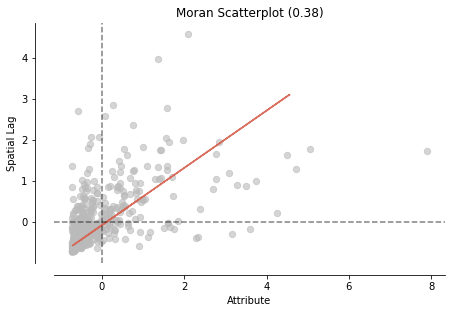

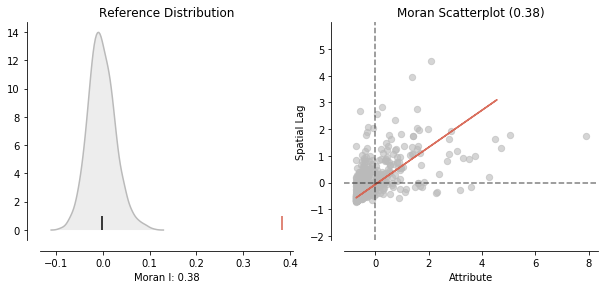

The p-value is 0.001


In [154]:

def Global_morans_I(gdf):
    y = gdf['total'].values # Choosing the value of interest. Here: the total number of disease cases for each county. 
    # Creating a Queen based contiguity weights matrix
    w = Queen.from_dataframe(gdf)
    w.transform = 'r'
    

    w = Queen.from_dataframe(gdf)
    moran = Moran(y, w) #Calling Moran's I function and passing the value y and the neighbourhood matrix w
    print('The global Moran\'s index is', moran.I)
    
    fig, ax = moran_scatterplot(moran, aspect_equal=True) # Calling the function and passing the calculated Moran's I
    plt.show() 
    
    
    #Plotting Moran's I diagram for our case to see how significant is our positive autocorrelation. 
    plot_moran(moran, zstandard=True, figsize=(10,4))
    plt.show()
    
    #Plotting the p-value of the result. p-value is a statistical measure of significance. 
    # any p-value smaller than 0.05 would be considerred statistically significant for the level of at least %95. 
    print('The p-value is',moran.p_sim)

Global_morans_I(ag_data2)


Since the global Moran's index is significantly bigger than zero we could say the data is clustered. 
From the positive sign of the index we could infer that there is a positive association among the polygons according to the total number of disease cases per county. 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/esda/moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


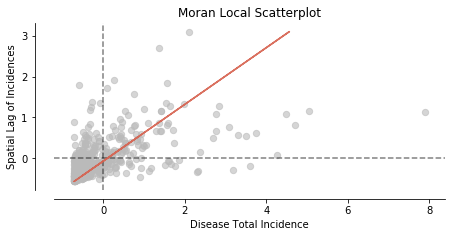

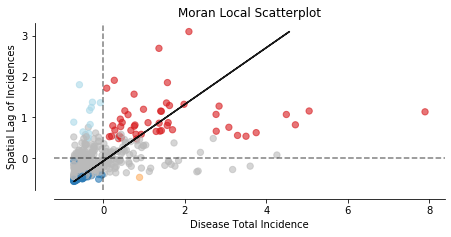

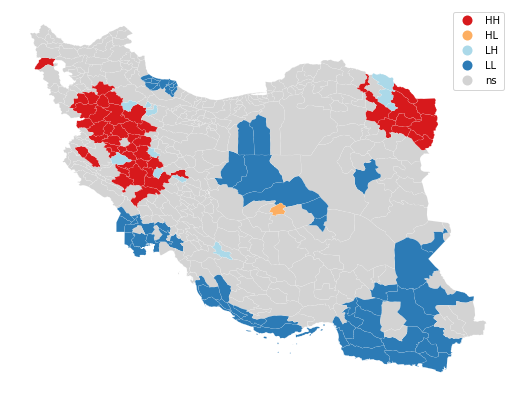

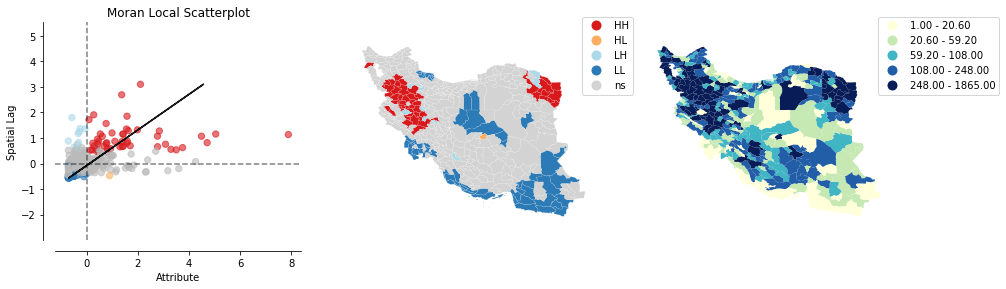

In [155]:

def Local_morans_I(gdf):


# calculate Local Moran's I to detect the disease hot and cold spots
    moran_loc = Moran_Local(y, w) 
    fig, ax = moran_scatterplot(moran_loc)
    ax.set_xlabel('Disease Total Incidence')
    ax.set_ylabel('Spatial Lag of Incidences')
    plt.show()
    
    # Running Moran's scatterplot function for the computed local Moran's I. 
    fig, ax = moran_scatterplot(moran_loc, p=0.05)
    ax.set_xlabel('Disease Total Incidence')
    ax.set_ylabel('Spatial Lag of Incidences')
    plt.show()
    
    
# plotting calculated local Moran's I map. 
    lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9))
    plt.show()
    
    # plotting local Moran's I result and the scatter plot for a better interpretation.
    
    plot_local_autocorrelation(moran_loc, gdf, 'total')
    plt.show()
    
Local_morans_I(ag_data2)


According to the results of local Moran's I analysis, there are two major disease hotspot with a statistical significance of %95. One of the disease clusters is located in northeastern parts of the country and the second one is situate in the northwest. 
This analysis also revealed Low-Low clusters which are the significant coldspots of the disease throughout the country. 

# Adding environmental Data
The environmental data is stored in a separate csv after being pulled from Google Earth Engine. The data is read in as a pandas  dataframe indexed by county with columns for each environmental variable for each month from 1996-2018. The data is aggregated as mean value by month.

The data was aggregated using the iran shapefile, so the county names already match those in the human and animal dataframes and do not need to be changed.  

### Function: addGregorian
The animal data contains only the jalali calendar date in the form of a jalali month and jalali year column. This function takes the dataframe, the year column name and the month column name and edits the dataframe in-place to add a gregorian year and month column. It utilizes the jdatetime module which easily converts jalali dates to gregorian.

#### pandas.apply
.apply() iterates a function over each row in a dataframe if axis=1 is specified and returns a series. In this case, it is used to create a new series which will be the year or month column.

#### lambda functions
Lambda functions are anonymous, meaning they are not given a name. In this case, they are useful because we need only a simple function for a short period of time. In the case of the first lambda below, it could also be written as:

def myfun(row):

    if (row[yearCol].isnumeric() and row[moCol].isnumeric()):
        jdatetime.date(int(row[yearCol]), int(row[moCol]), 1).togregorian().strftime('%y')
    else:
        None

.apply() applies this function to each row to generate the gregorian year and month

In [18]:
import jdatetime

def addGregorian(data, yearCol, moCol):
    """
    Adds gregorian month and year columns to a dataframe based on jalali month and year columns. 
    Assumes first day of jalali month, since day is not given.
    """
    #The apply function iterates a function over each row in a dataframe (axis=1 specifies row not column)
    #The function creates a jalali date object for each row from the jalali year and month. 
    #Then, it converts it to a gregorian date and extracts the year or month. 
    #If the jalali year and date are not numeric (e.g. Null as a string) then the year and month get None values. 
    data['year']=data.apply(lambda row: jdatetime.date(int(row[yearCol]), int(row[moCol]), 1).togregorian()\
                            .strftime('%y') if (row[yearCol].isnumeric() and row[moCol].isnumeric()) else None, axis=1)
    data['month']=data.apply(lambda row: jdatetime.date(int(row[yearCol]), int(row[moCol]), 1).togregorian()\
                             .strftime('%m') if (row[yearCol].isnumeric() and row[moCol].isnumeric()) else None, axis=1)

## Function: addEnvData
The environmental dataframe is indexed by county and has column names following the "variableName_YYYYMM" format. The following are some column names in the dataframe: 

mean_2m_air_temperature_200801

mean_total_precipitation_201008

mean_ndvi_201811

Because elevation doesn't typically change with time, there is only one elevation column named mean_elevation.

#### .apply() and lambda functions
Just like addGregorian(), addEnvData() uses apply and lambda functions to extract data from the environmental dataframe.
#### row.County
row.County is used to get the county name of the row, and to locate the corresponding row in the environmental dataframe.
#### Appending YYYYMM to end of column name
For each row, the _YYYYMM sequence is added to the end of the variable name to choose data from the correct column in the environmental dataframe.

In [19]:
def addEnvData(data, envDF, yearCol, moCol):
    """
    Takes two dataframes: 
    data-  a dataframe indexed by county, contains at least a year and month column
    envDF- a dataframe indexed by county, contains  columns for each environmental variable 
           for each month from 1996-2018. The data is aggregated as mean by month. 
    
    The function pulls the corresponding county/date value for each environmental data variable
    and adds them as a new column in 'data'.
    """
    #The apply function iterates a function over each row in a dataframe (axis=1 specifies row)
    #envDF.loc[row.County] sorts the environmental data to the correct county. 
    #The next bracket selects a column by creating a datestring in the correct format. .zfill is required to make sure months are in '04' format instead of '4'
    data['mean_2m_air_temperature'] = data.apply(lambda row: envDF.loc[row.County]['mean_2m_air_temperature_20'+row[yearCol]+row[moCol].zfill(2)] if (row[yearCol]!=None and row.County in envDF.index) else None, axis=1)
    data['mean_total_precipitation'] = data.apply(lambda row: envDF.loc[row.County]['total_precipitation_20'+row[yearCol]+row[moCol].zfill(2)] if (row[yearCol]!=None and row.County in envDF.index) else None, axis=1)
    data['mean_ndvi'] = data.apply(lambda row: envDF.loc[row.County]['mean_20'+row[yearCol]+row[moCol].zfill(2)] if (row[yearCol]!=None and row.County in envDF.index) else None, axis=1)
    #Elevation doesn't change with time, so the date selector is not necessary
    data['mean_elevation'] = data.apply(lambda row: envDF.loc[row.County]['mean_elevation'] if (row.County in envDF.index) else None, axis=1)


The human data needs to be cleaned just a little bit. Some float-type NaN values need to be converted to 'Null' strings, otherwise the functions above won't function.

For the animal data, the 'county' column just needs to be capitalized.

In [ ]:
## Read Environmental Data
envFP=os.path.join(fp, 'Data', 'allParams.csv')
envData = pd.read_csv(envFP, index_col='ADM2_EN')

## Clean up human data, add date column
human_sp_data.loc[pd.isna(human_sp_data['Outbreak_yr']), 'Outbreak_yr']='Null'
addGregorian(human_sp_data, 'Outbreak_yr', 'Outbreak_mth')

## Clean up animal data
ani_sp_data.rename(columns={"county": "County"}, inplace=True)

## Adding environmental data to both dataframes
addEnvData(ani_sp_data, envData, 'year', 'month')
addEnvData(human_sp_data, envData, 'year', 'month')

# The Future Steps

- The steps ahead of this project would be: 
    * Incorporating animal vaccination 
    - Assessing possible correlation between animal and human data
    - implementing a multiple linear regression analysis incorporating environmental variables and the standard disease incidence per 100000 people per county. 
    